In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
try:
    from enlighten_inference import EnlightenOnnxModel
except ImportError:
    !pip install git+https://github.com/arsenyinfo/EnlightenGAN-inference
    from enlighten_inference import EnlightenOnnxModel
import kornia
from kapture_localization.matching.matching import MatchPairNnTorch
from torch.nn.functional import grid_sample
import torch

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/home/andrei/miniconda3/envs/enGAN/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def orb_feature_exctraction(img):
    orb = cv2.ORB_create()
    kp, descr = orb.detectAndCompute(img, None)
    orb_img = cv2.drawKeypoints(img, kp, None)
    return orb_img, kp, descr

def sift_feature_exctraction(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, descr = sift.detectAndCompute(img, None)
    sift_img = cv2.drawKeypoints(img, kp, None)
    return sift_img, kp, descr

In [5]:
def extract_key_points_coordinates(keypoints_1, keypoints_2):
    keypoints_1_x_y = []
    keypoints_2_x_y = []
    for points in keypoints_1:
        keypoints_1_x_y.append(list(points.pt))
    for points in keypoints_2:
        keypoints_2_x_y.append(list(points.pt))
    return np.asarray(keypoints_1_x_y), np.asarray(keypoints_2_x_y)

def feature_matching(descriptors_1, descriptors_2, norm):
    bf = cv2.BFMatcher(norm, crossCheck=True)
    matches = bf.match(descriptors_1, descriptors_2)
    return matches

def extract_data(matches):
    matches_dist = []
    matches_queryIdx = []
    matches_trainIdx = []
    for points in matches:
        matches_dist.append(int(points.distance))
        matches_queryIdx.append(int(points.queryIdx))
        matches_trainIdx.append(int(points.trainIdx))
    return matches_dist, matches_queryIdx, matches_trainIdx
        
def matched_keypoints(keypoints_1_x_y, keypoints_2_x_y,
                      matches_queryIdx, matches_trainIdx, matches_dist):
    matched_keypoints1 = []
    matched_keypoints2 = []
    i = 0 
    for match in matches_dist:
        matched_keypoints1.append(keypoints_1_x_y[int(matches_queryIdx[i])])
        matched_keypoints2.append(keypoints_2_x_y[int(matches_trainIdx[i])])
        i = i + 1

    return np.array(matched_keypoints1), np.array(matched_keypoints2)

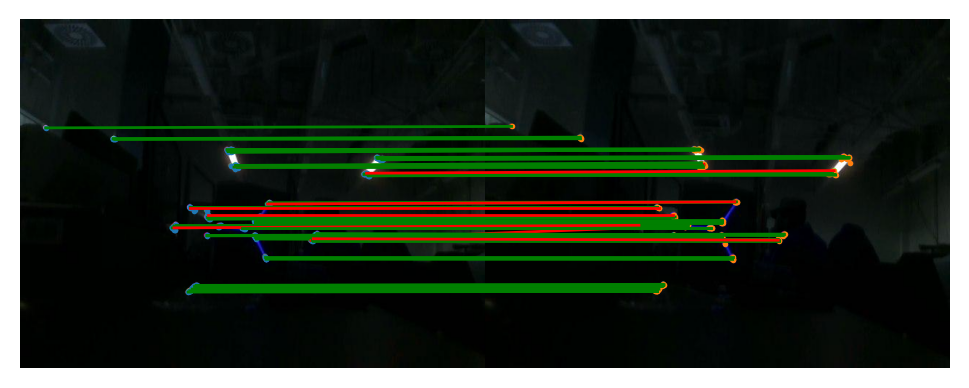

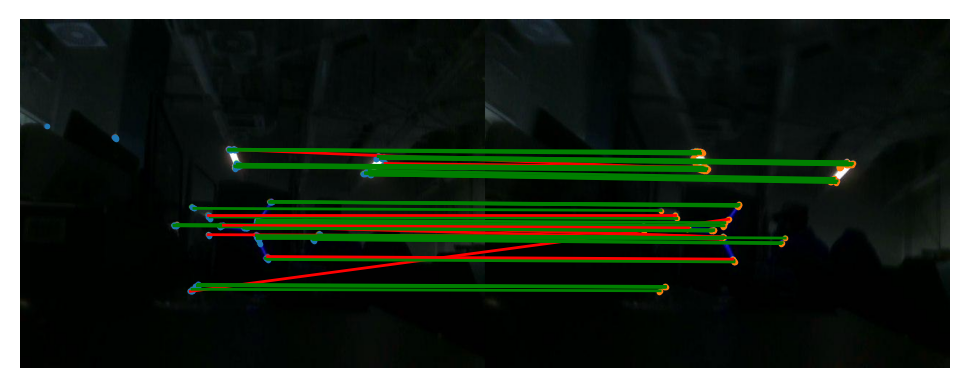

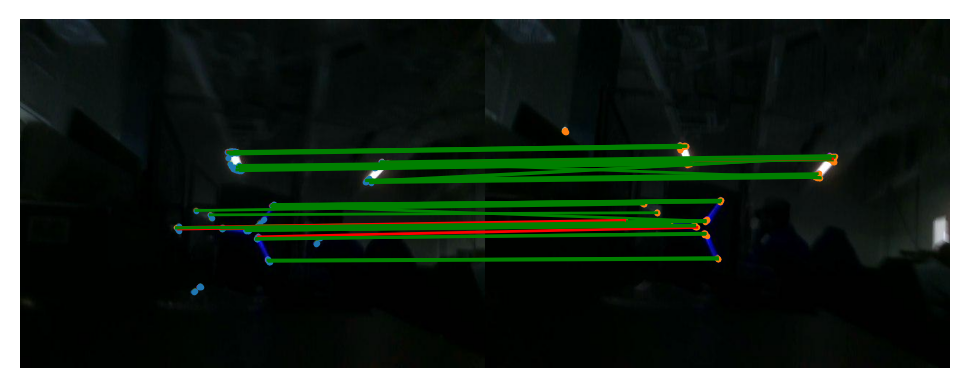

In [6]:
dataset_path = os.path.abspath(os.getcwd()) + "/data/proceed_data/"
dataset_images = os.listdir(dataset_path)
index = 0
good_features = []

while index < len(dataset_images) - 1:
    path1 = dataset_path + dataset_images[index]
    path2 = dataset_path + dataset_images[index + 1]
    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)
    
    # data extraction
    img_1, keypoints_1, descriptors_1 = orb_feature_exctraction(img1)
    img_2, keypoints_2, descriptors_2 = orb_feature_exctraction(img2)
    
    # data converstion 
    keypoints_1_x_y, keypoints_2_x_y = extract_key_points_coordinates(keypoints_1, keypoints_2)
    matches = feature_matching(descriptors_1, descriptors_2, cv2.NORM_HAMMING)
    matches_dist, matches_queryIdx, matches_trainIdx = extract_data(matches)
    
    # data matching
    matched_keypoints1, matched_keypoints2 = matched_keypoints(keypoints_1_x_y, keypoints_2_x_y,
                                                                       matches_queryIdx, matches_trainIdx,
                                                                       matches_dist)
    fundamental_matrix, mask = cv2.findFundamentalMat(matched_keypoints1, matched_keypoints2, cv2.UsacParams())
    
    good_features.append(np.count_nonzero(mask==1))
    
    plt.figure(dpi=200)
    output_image = np.concatenate([img_1, img_2], axis=1)
    plt.imshow(output_image)
    plt.scatter(keypoints_1_x_y[:, 0], keypoints_1_x_y[:, 1], s=1)
    plt.scatter(keypoints_2_x_y[:, 0] + 640, keypoints_2_x_y[:, 1], s=1)
    i=0
    for points in matches:
        color = "green" if mask[i, 0] else "red" 
        i = i + 1
        plt.plot([keypoints_1_x_y[int(points.queryIdx), 0], keypoints_2_x_y[int(points.trainIdx), 0] + 640], 
                 [keypoints_1_x_y[int(points.queryIdx), 1], keypoints_2_x_y[int(points.trainIdx), 1]], linewidth=1, c=color)   
    plt.axis('off');
    
    index += 1

In [7]:
print(good_features)

[92, 69, 59]
